In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Activation
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
csv_path = 'https://query1.finance.yahoo.com/v7/finance/download/MATIC-USD?period1=1548720000&period2=1650672000&interval=1d&events=history&includeAdjustedClose=true'
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-28,0.004521,0.004545,0.004317,0.004421,0.004421,8408136
1,2019-04-29,0.004418,0.004492,0.003471,0.003471,0.003471,8267044
2,2019-04-30,0.003462,0.005078,0.003458,0.004478,0.004478,25072706
3,2019-05-01,0.004440,0.004673,0.004071,0.004374,0.004374,10567352
4,2019-05-02,0.004366,0.004700,0.004096,0.004198,0.004198,6714908
...,...,...,...,...,...,...,...
1087,2022-04-19,1.421118,1.447452,1.396778,1.428176,1.428176,630841720
1088,2022-04-20,1.428233,1.463450,1.401330,1.417744,1.417744,648103958
1089,2022-04-21,1.417712,1.465750,1.368370,1.379862,1.379862,652619938
1090,2022-04-22,1.379697,1.496747,1.374800,1.399139,1.399139,1281222594


In [5]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

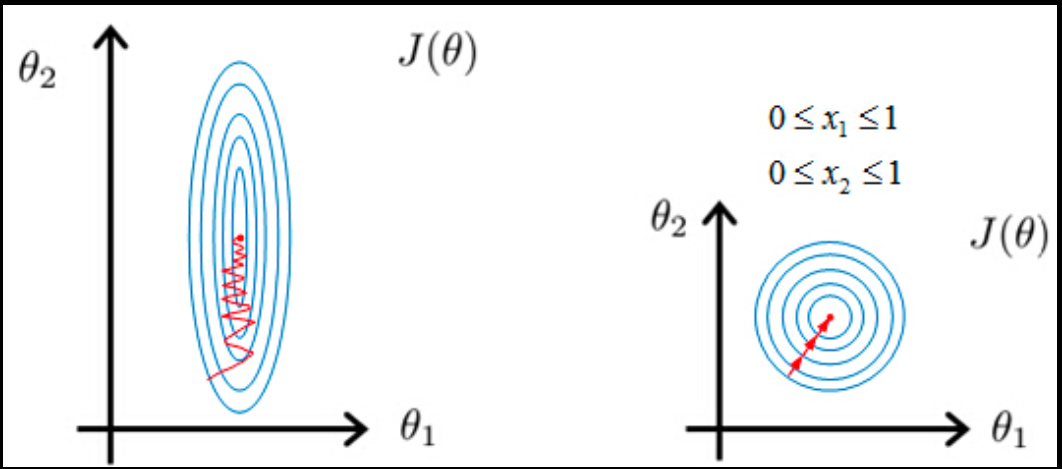

In [6]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [7]:
SEQ_LEN = 100

def dataset_generator_lstm(dataset, look_back=5):
    X_data, y_data = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        X_data.append(window_size_x)
        y_data.append(dataset[i + look_back, 0])
    return np.array(X_data), np.array(y_data)

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [8]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 99, 198)          80784     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 198)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 99, 396)          630432    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 99, 396)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 99, 198)          393624    
 nal)                                                            
                                                        

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

BATCH_SIZE = 64

checkpoint_path = 'MATIC_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.0211
Epoch 00001: val_loss improved from inf to 0.04405, saving model to MATIC_model.hdf5
14/14 [==============================] - 19s 307ms/step - loss: 0.0211 - val_loss: 0.0440
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0491
Epoch 00002: val_loss improved from 0.04405 to 0.02251, saving model to MATIC_model.hdf5
14/14 [==============================] - 1s 99ms/step - loss: 0.0496 - val_loss: 0.0225
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0198
Epoch 00003: val_loss did not improve from 0.02251
14/14 [==============================] - 1s 83ms/step - loss: 0.0195 - val_loss: 0.0382
Epoch 4/100
13/14 [==========================>...] - ETA: 0s - loss: 0.0526
Epoch 00004: val_loss did not improve from 0.02251
14/14 [==============================] - 1s 84ms/step - loss: 0.0517 - val_loss: 0.0795
Epoch 5/100
13/14 [==========================>...] - ETA: 0s - los

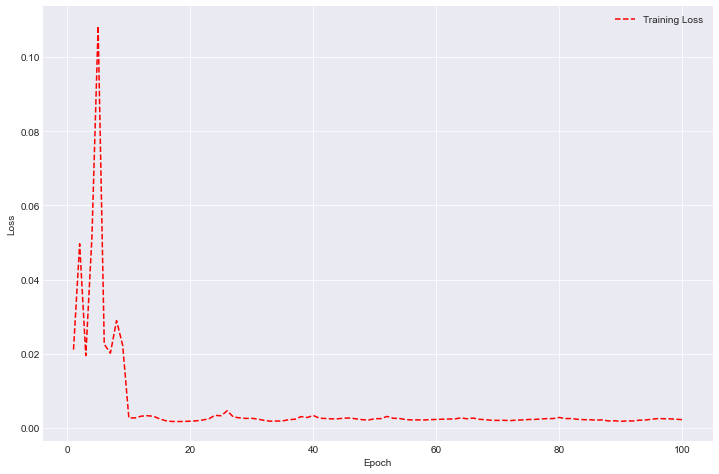

In [11]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

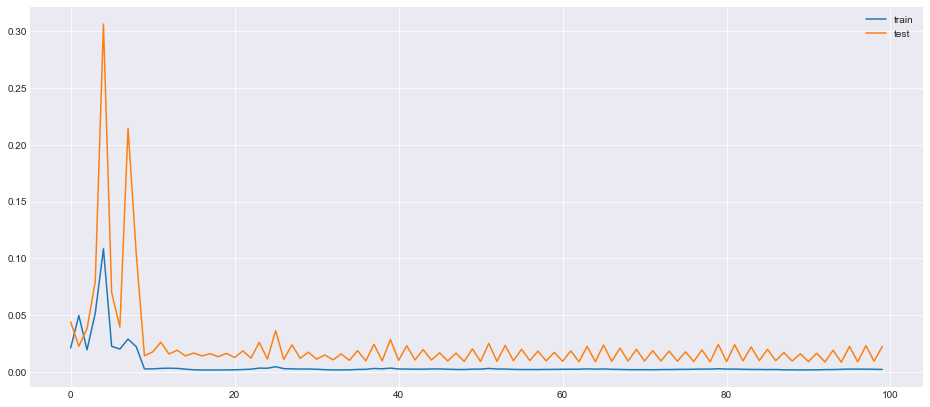

In [12]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

In [14]:
y_pred = model_from_saved_checkpoint.predict(X_test)

In [15]:
y_pred_transformed = scaler.inverse_transform(y_pred)
y_test_transformed = scaler.inverse_transform(y_test)

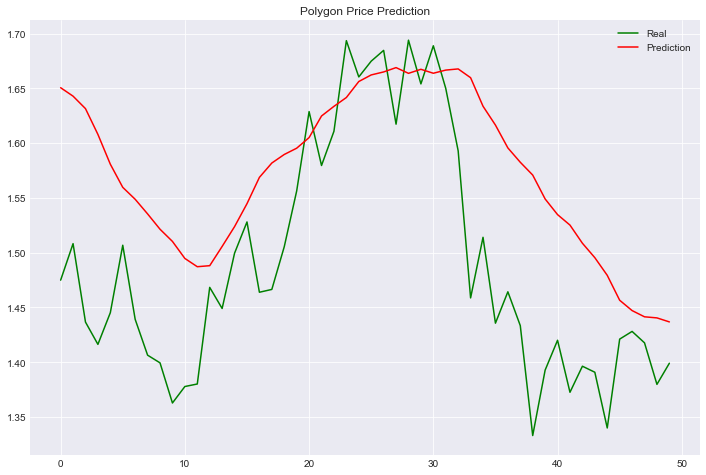

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_transformed, color='green', label='Real')
plt.plot(y_pred_transformed, color='red', label='Prediction')
plt.title('Polygon Price Prediction')
plt.legend()
plt.show()

In [17]:
mean_absolute_error(y_pred_transformed, y_test_transformed)

0.08888274902801514